In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sympy import *
import time
from sympy.parsing.sympy_parser import parse_expr
from kda import plotting, graph_utils, calculations, ode
from kda.plotting import *

In [2]:
k12 = 1
k21 = 1
k23 = 1
k32 = 1
k43 = 1
k34 = 1
k14 = 1
k41 = 1

K4 = np.array([[0, k12, 0, k14],
               [k21, 0, k23, 0],
               [0, k32, 0, k34],
               [k41, 0, k43, 0]])

k35 = 1
k53 = 1
k15 = 1
k51 = 1

K5 = np.array([[0, k12, 0, k14, k15],
               [k21, 0, k23, 0,   0],
               [0, k32, 0, k34, k35],
               [k41, 0, k43, 0,   0],
               [k51, 0, k53, 0,   0]])

rate_names4 = ["k12", "k21", "k23", "k32", "k43", "k34", "k14", "k41"]
rate_names5 = ["k12", "k21", "k23", "k32", "k43", "k34", "k14", "k41", "k35", "k53", "k15", "k51"]

In [3]:
G4 = nx.MultiDiGraph()
graph_utils.generate_edges(G4, K4)

pos4 = {0 : [0, 1],
        1 : [-1, 0],
        2 : [0, -1],
        3 : [1, 0]}

G5 = nx.MultiDiGraph()
graph_utils.generate_edges(G5, K5)

pos5 = {0 : [0, 1],
        1 : [-1, 0],
        2 : [0, -1],
        3 : [0.7, 0],
        4 : [1.3, 0]}

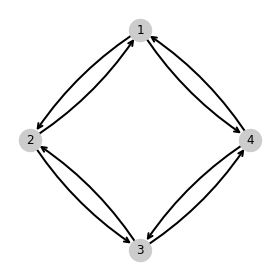

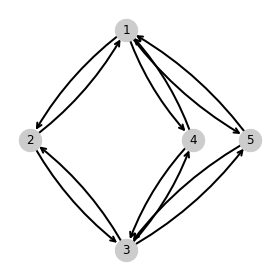

In [4]:
for graph, node_pos in zip([G4, G5], [pos4, pos5]):
    plotting.draw_diagrams(graph, pos=node_pos)

# State Probability Functions

In [5]:
probs4 = calculations.calc_state_probs(G4, key='name', output_strings=True)
probs5 = calculations.calc_state_probs(G5, key='name', output_strings=True)

# Plot Probabilities

In [6]:
def gen_rate_dict(K):
    i, j = np.nonzero(K)
    idx_pairs = np.column_stack((i, j))
    rate_dict = {}
    for (i, j) in idx_pairs:
        rate_dict[f"k{i+1}{j+1}"] = K[i, j]
    return rate_dict

In [7]:
def plot_probs(
    K_stat,
    K_dyn,
    leak_arr,
    leak_key,
    rn_stat,
    rn_dyn,
    probs_stat,
    probs_dyn,
    filename="",
):

    rev_arr = 1 / leak_arr
    rev_key = leak_key[0] + leak_key[2] + leak_key[1]

    dict_stat = gen_rate_dict(K_stat)
    # create static (unchanging) state probability functions
    stat_probs = []
    for prob_str in probs_stat:
        f = lambdify(rn_stat, prob_str)
        p = np.ones_like(leak_arr, dtype=np.float64) * f(**dict_stat)
        stat_probs.append(p)

    dict_dyn = gen_rate_dict(K_dyn)
    dict_dyn[leak_key] = leak_arr
    dict_dyn[rev_key] = rev_arr

    # create dynamic (changing) state probability functions
    dyn_probs = []
    for prob_str in probs_dyn:
        f = lambdify(rn_dyn, prob_str)
        p = f(**dict_dyn)
        dyn_probs.append(p)

    x_arr = leak_arr / rev_arr

    fig = plt.figure(figsize=(4, 3), tight_layout=True)
    ax = fig.add_subplot(111)

    stat_colors = ["black", "grey", "brown"]
    dyn_colors = ["blue", "red", "green", "orange", "purple"]
    for i, pi in enumerate(stat_probs):
        color = stat_colors[i]
        label = r"$p_{%s}$" % (i + 1)
        ax.semilogx(x_arr, pi, color=color, ls="--", label=label)

    for i, pi in enumerate(dyn_probs):
        color = dyn_colors[i]
        label = r"$p_{%s}$" % (f"{i + 1}, dang")
        ax.semilogx(x_arr, pi, color=color, ls="--", label=label)

    ax.axvline(x=1, ymin=0, ymax=1, color="black", ls="--")
    ax.set_ylim(-0.05, 1.05)
    ax.set_title("State Probabilities")
    for_str = r"$k_{%s}$" % (leak_key[1:])
    rev_str = r"$k_{%s}$" % (rev_key[1:])
    x_label = f"{for_str}/{rev_str}"
    ax.set_xlabel(x_label)
    ax.legend(bbox_to_anchor=(1, 1))
    if filename:
        plt.savefig(filename, dpi=300)

In [13]:
Aon = 1e10
Aoff = 1e3
Bon = 1e7
Boff = 1e4
k_conf = 100
Ain = 10 ** -6.5
Aout = 10 ** -7.5
Bin = 1e-3
Bout = 1e-3

# regenerate the rate matrices with new values
k12 = kon*cin
k21 = koff
k43 = koff
k34 = kon*cout
k41, k14 = k_conf, k_conf
k23, k32 = k_conf, k_conf

K4 = np.array([[0, k12, 0, k14],
               [k21, 0, k23, 0],
               [0, k32, 0, k34],
               [k41, 0, k43, 0]])

k34, k35 = kon*cout, kon*cout
k43, k53 = koff, koff
k14, k15 = k_conf, k_conf
k41, k51 = k_conf, k_conf

K5 = np.array([[0, k12, 0, k14, k15],
               [k21, 0, k23, 0,   0],
               [0, k32, 0, k34, k35],
               [k41, 0, k43, 0,   0],
               [k51, 0, k53, 0,   0]])

In [14]:
bind_arr = kon*cout * np.logspace(-2, 2, 101)
conf_arr = k_conf * np.logspace(-2, 2, 101)

In [15]:
funcs4 = []
for prob_str in probs4:
    f = lambdify(rate_names4, prob_str)
    p = np.ones_like(leak_arr, dtype=np.float64) * f(**gen_rate_dict(K4))
    funcs4.append(p)

bind_for = bind_arr
bind_rev = 1 / bind_for
conf_for = conf_arr
conf_rev = 1 / conf_for
rate_dict5 = gen_rate_dict(K5)
rate_dict5["k34"] = bind_for 
# rate_dict5["k41"] = conf_for
rate_dict5["k43"] = bind_rev 
# rate_dict5["k14"] = conf_rev

funcs5 = []
for prob_str in probs5:
    f = lambdify(rate_names5, prob_str)
    p = np.ones_like(leak_arr, dtype=np.float64) * f(**rate_dict5)
    funcs5.append(p)

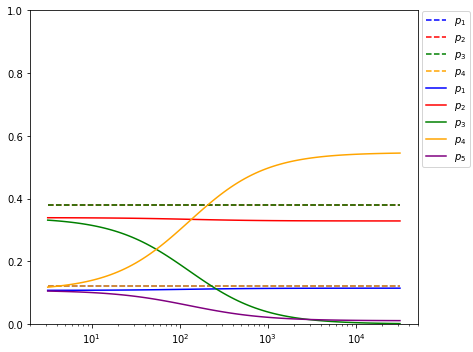

In [18]:
colors = ["blue", "red", "green", "orange", "purple"]

fig = plt.figure(figsize=(6, 5), tight_layout=True)
ax = fig.add_subplot(111)
for i, f in enumerate(funcs4):
    label = f"$p_{i+1}$"
    ax.semilogx(bind_arr, f, ls="--", color=colors[i], label=label)
for i, f in enumerate(funcs5):
    label = f"$p_{i+1}$"
    ax.semilogx(bind_arr, f, color=colors[i], label=label)
ax.set_ylim(0, 1)
fig.legend(bbox_to_anchor=(1.1, 0.96))

# Plot Net Cycle Flux

In [19]:
graph_utils.find_all_unique_cycles(G5)

[[0, 4, 2, 3], [0, 4, 2, 1], [0, 3, 2, 1]]

In [ ]:
order = [0, 1] # CCW is positive

J4 = calculations.calc_net_cycle_flux(G4, [0, 1, 2], order, key='name', output_strings=True)
J5 = calculations.calc_net_cycle_flux(G5, [0, 1, 2], order, key='name', output_strings=True)

flux3 = lambdify(rate_names3, J_3_state)
flux3d = lambdify(rate_names3d, J_3_state_dangling)
flux4 = lambdify(rate_names4, J_4_state)

In [ ]:
def plot_net_cycle_flux(
    K_stat, K_dyn, leak_arr, leak_key, flux_stat, flux_dyn, filename=""
):

    rev_arr = 1 / leak_arr
    rev_key = leak_key[0] + leak_key[2] + leak_key[1]

    dict_stat = gen_rate_dict(K_stat)
    J_stat = np.ones_like(leak_arr, dtype=np.float64) * flux_stat(**dict_stat)

    dict_dyn = gen_rate_dict(K_dyn)
    dict_dyn[leak_key] = leak_arr
    dict_dyn[rev_key] = rev_arr
    J_dyn = flux_dyn(**dict_dyn)

    fig = plt.figure(figsize=(4, 3), tight_layout=True)
    ax = fig.add_subplot(111)
    ax.semilogx(leak_arr, J_stat, color="blue", ls="--", label=r"$J_{exp}$")
    ax.semilogx(leak_arr, J_dyn, color="red", ls="-", label=r"$J_{dang}$")

    ax.axvline(x=1, ymin=0, ymax=1, color="black", ls="--")
    ax.set_title("Net Cycle Flux")
    for_str = r"$k_{%s}$" % (leak_key[1:])
    rev_str = r"$k_{%s}$" % (rev_key[1:])
    x_label = f"{for_str}/{rev_str}"
    ax.set_xlabel(x_label)
    ax.legend(bbox_to_anchor=(1, 1))
    if filename:
        plt.savefig(filename, dpi=300)

In [ ]:
leak_arr = np.logspace(-4, 4, 101)

In [ ]:
plot_net_cycle_flux(K_stat=k3, K_dyn=k3d, leak_arr=leak_arr, leak_key="k43", flux_stat=flux3, flux_dyn=flux3d, filename="3_state_vs_dangling_node_net_cycle_flux.png")

In [ ]:
plot_net_cycle_flux(K_stat=k3, K_dyn=k4, leak_arr=leak_arr, leak_key="k41", flux_stat=flux3, flux_dyn=flux4, filename="3_state_vs_4_state_net_cycle_flux.png")

## Flux limits

In [ ]:
# NOTE: would need to re-enter ALL symbols to get SymPy to work properly here...
# k43, k34 = symbols("k43, k34")

In [ ]:
# J_3_state_dangling

In [ ]:
# limit(J_3_state_dangling, k34, 0)

In [ ]:
# limit(J_3_state_dangling, k43, 0)